# OCR a document, form, or invoice with Tesseract and OpenCV

### Install the necessary packages

In [ ]:
!sudo apt-get install tesseract-ocr
!pip install pytesseract

In [1]:
%cd ocr-document

/content/ocr-document


### Import Packages

In [2]:
# import the necessary packages
from pyimagesearch.alignment import align_images
from matplotlib import pyplot as plt
from collections import namedtuple
import pytesseract
import argparse
import imutils
import cv2

### Function to display images in Jupyter Notebooks and Google Colab

In [3]:
def plt_imshow(title, image):
	# convert the image frame BGR to RGB color space and display it
	image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
	plt.imshow(image)
	plt.title(title)
	plt.grid(False)
	plt.show()

### Implementing our document OCR script with OpenCV and Tesseract

In [4]:
def cleanup_text(text):
	# strip out non-ASCII text so we can draw the text on the image
	# using OpenCV
	return "".join([c if ord(c) < 128 else "" for c in text]).strip()

In [5]:
# since we are using Jupyter Notebooks we can replace our argument
# parsing code with *hard coded* arguments and values
args = {
	"image": "scans/scan_03.jpg",
	"template": "form_w4.png"
}

In [6]:
# create a named tuple which we can use to create locations of the
# input document which we wish to OCR
OCRLocation = namedtuple("OCRLocation", ["id", "bbox",
	"filter_keywords"])

# define the locations of each area of the document we wish to OCR
OCR_LOCATIONS = [
	OCRLocation("step1_first_name", (265, 237, 751, 106),
		["middle", "initial", "first", "name"]),
	OCRLocation("step1_last_name", (1020, 237, 835, 106),
		["last", "name"]),
	OCRLocation("step1_address", (265, 336, 1588, 106),
		["address"]),
	OCRLocation("step1_city_state_zip", (265, 436, 1588, 106),
		["city", "zip", "town", "state"]),
	OCRLocation("step5_employee_signature", (319, 2516, 1487, 156),
		["employee", "signature", "form", "valid", "unless",
		 	"you", "sign"]),
	OCRLocation("step5_date", (1804, 2516, 504, 156), ["date"]),
	OCRLocation("employee_name_address", (265, 2706, 1224, 180),
		["employer", "name", "address"]),
	OCRLocation("employee_ein", (1831, 2706, 448, 180),
		["employer", "identification", "number", "ein"]),
]

In [7]:
# load the input image and template from disk
print("[INFO] loading images...")
image = cv2.imread(args["image"])
template = cv2.imread(args["template"])

# align the images
print("[INFO] aligning images...")
aligned = align_images(image, template)

[INFO] loading images...
[INFO] aligning images...


In [8]:
# initialize a results list to store the document OCR parsing results
print("[INFO] OCR'ing document...")
parsingResults = []

# loop over the locations of the document we are going to OCR
for loc in OCR_LOCATIONS:
	# extract the OCR ROI from the aligned image
	(x, y, w, h) = loc.bbox
	roi = aligned[y:y + h, x:x + w]

	# OCR the ROI using Tesseract
	rgb = cv2.cvtColor(roi, cv2.COLOR_BGR2RGB)
	text = pytesseract.image_to_string(rgb)

    # break the text into lines and loop over them
	for line in text.split("\n"):
		# if the line is empty, ignore it
		if len(line) == 0:
			continue

		# convert the line to lowercase and then check to see if the
		# line contains any of the filter keywords (these keywords
		# are part of the *form itself* and should be ignored)
		lower = line.lower()
		count = sum([lower.count(x) for x in loc.filter_keywords])

		# if the count is zero then we know we are *not* examining a
		# text field that is part of the document itself (ex., info,
		# on the field, an example, help text, etc.)
		if count == 0:
			# update our parsing results dictionary with the OCR'd
			# text if the line is *not* empty
			parsingResults.append((loc, line))

[INFO] OCR'ing document...


In [9]:
# initialize a dictionary to store our final OCR results
results = {}

# loop over the results of parsing the document
for (loc, line) in parsingResults:
	# grab any existing OCR result for the current ID of the document
	r = results.get(loc.id, None)

	# if the result is None, initialize it using the text and location
	# namedtuple (converting it to a dictionary as namedtuples are not
	# hashable)
	if r is None:
		results[loc.id] = (line, loc._asdict())

	# otherwise, there exists an OCR result for the current area of the
	# document, so we should append our existing line
	else:
		# unpack the existing OCR result and append the line to the
		# existing text
		(existingText, loc) = r
		text = "{}\n{}".format(existingText, line)

		# update our results dictionary
		results[loc["id"]] = (text, loc)

In [10]:
# loop over the results
for (locID, result) in results.items():
	# unpack the result tuple
	(text, loc) = result

	# display the OCR result to our terminal
	print(loc["id"])
	print("=" * len(loc["id"]))
	print("{}\n\n".format(text))

	# extract the bounding box coordinates of the OCR location and
	# then strip out non-ASCII text so we can draw the text on the
	# output image using OpenCV
	(x, y, w, h) = loc["bbox"]
	clean = cleanup_text(text)

	# draw a bounding box around the text
	cv2.rectangle(aligned, (x, y), (x + w, y + h), (0, 255, 0), 2)

	# loop over all lines in the text
	for (i, line) in enumerate(text.split("\n")):
		# draw the line on the output image
		startY = y + (i * 70) + 40
		cv2.putText(aligned, line, (x, startY),
			cv2.FONT_HERSHEY_SIMPLEX, 1.8, (0, 0, 255), 5)

step1_first_name
Shiela



step1_last_name
Jimenez



step1_address
Pateros Metro Manila



step1_city_state_zip
   
 
  
Sampaguita Street, Stro. Rosario
 



step5_employee_signature
Shiela Jimenez



step5_date
2020/08/14



employee_name_address
 
Philippines Genome Center
A. Maria Regidor Street, University of the Philippines
Diliman, Quezon City



employee_ein
 
24 -04142021





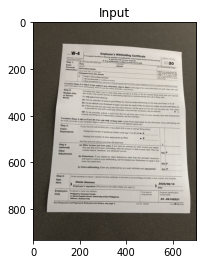

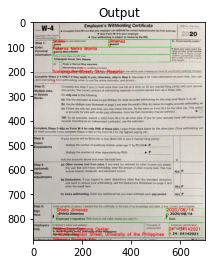

In [11]:
# show the input and output images, resizing it such that they fit
# on our screen
plt_imshow("Input", imutils.resize(image, width=700))
plt_imshow("Output", imutils.resize(aligned, width=700))